<a href="https://colab.research.google.com/github/muntazir02/maven/blob/main/KMean_Clustering_Foods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Foods](https://www.shutterstock.com/shutterstock/photos/632638817/display_1500/stock-photo-panoramic-wide-organic-food-background-concept-with-full-frame-pile-of-fresh-vegetables-and-fruits-632638817.jpg)

# Text Clustering K-Means 

## Read Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
%matplotlib inline
import plotly.express as px
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS

#Libraries for vectorisation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from fuzzywuzzy import fuzz

#Libraries for clustering
from sklearn.cluster import KMeans

#Libraries for preprocessing
from gensim.parsing.preprocessing import remove_stopwords
import string
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import webcolors

# Set display options to squeeze more data in rows
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 500)


# https://towardsdatascience.com/two-essential-pandas-add-ons-499c1c9b65de
# pip install qgrid
# jupyter nbextension enable --py --sys-prefix qgrid
import qgrid

# only required if you have not enabled the ipywidgets nbextension yet
# jupyter nbextension enable --py --sys-prefix widgetsnbextension
#to show a df simply use the below:
# qgrid.show_grid(df)

In [ ]:
import os,glob
#os.chdir('C:/_Muntazir/_Analyses/KMeans')
print(os.getcwd())  # Prints the current working directory

# Remove Previous Output files in the location 
#for filename in glob.glob("C:/_Muntazir/_Analyses/KMeans/Output*"):
#    os.remove(filename) 

C:\Users\Muntazir.Mehdi


In [ ]:
#Download once if using NLTK for preprocessing
import nltk
nltk.download('punkt')
nltk.download("wordnet")
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Muntazir.Mehdi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Muntazir.Mehdi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Muntazir.Mehdi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Read the Data File

### Read Data 

In [ ]:
###
### LOAD DATA
###
#Load data set
df = pd.read_csv('GlobalProductListwSales.csv')
# Convert Text Columns to lowercase - so that case doesnt affect the downstream work
df['Department']=df['Department'].str.lower()
df['Category']=df['Category'].str.lower()
df['Subcategory']=df['Subcategory'].str.lower()
df['Product']=df['Product'].str.lower()
df['Uom']=df['Uom'].str.lower()

###
### FillNAs
###
#df['Detail']=df['Detail'].fillna('')
df.fillna({'Department':'', 'Category':'', 'Subcategory':'','Product':'','Uom':'','UPC':'0',
          'Jan-22':'0','Feb-22':'0','Mar-22':'0','Apr-22':'0','May-22':'0','Jun-22':'0','Jul-22':'0',
          'Aug-22':'0','Sep-22':'0','Oct-22':'0',}, inplace=True)

###
### Total Sales & Sort
###
#Create a Total Sales 2022 Calendar Year Col
#df['Sales2022'] = df['Jan-22']+df['Feb-22']+df['Mar-22']+df['Apr-22']+df['May-22']+df['Jun-22']+df['Jul-22']+df['Aug-22']+df['Sep-22']+df['Oct-22']
df['Sales2022'] = df['Jan-22'].apply(lambda x: float(x)) + df['Feb-22'].apply(lambda x: float(x))+df['Mar-22'].apply(lambda x: float(x)) +df['Apr-22'].apply(lambda x: float(x)) +df['May-22'].apply(lambda x: float(x))+df['Jun-22'].apply(lambda x: float(x))+df['Jul-22'].apply(lambda x: float(x))+df['Aug-22'].apply(lambda x: float(x))+df['Sep-22'].apply(lambda x: float(x))+df['Oct-22'].apply(lambda x: float(x))


#Now Sort by Client, Dept, Sales2022, This will be crucial while calculating cumsum and picking top 80% of the sales contributors
df = df.sort_values(by = ['Client', 'Department','Sales2022'], ascending = [True, True, False])


###
### Sales Contribution and Running Cummulative Percentage
###
# Let Calculate Total Sales Contribution, & Running PCT (this can be used to pick top N% sales contr products now)
df['SalesContr'] = df.groupby(['Client','Department'])['Sales2022'].apply(lambda x: x / x.sum())
df['CumSum'] = df.groupby(['Client','Department'])['Sales2022'].cumsum()
df['RunningPct'] = df['CumSum'] / df.groupby(['Client','Department'])['Sales2022'].transform('sum')

# Combining the  Cat / SubCat Names in Single Name String. 
#df['Detail'] = df['Category'] + ' ' + df['Subcategory'] + ' ' + df['Product']
df['Detail'] = df['Subcategory'] + ' ' + df['Product'] #Just trying SubCat. Cat has too much repetition, thats showing up as end results
 

# Remove Monthly sales columns, these are no longer needed
df = df.drop(['Uom', 'Jan-22', 'Feb-22' , 'Mar-22' , 'Apr-22' , 'May-22' , 'Jun-22' , 'Jul-22' , 
           'Aug-22' , 'Sep-22' , 'Oct-22', 'CumSum'], axis=1)

df_allitems = df #saving dataframe for later use

### Summary - Overall

In [ ]:
# # Looking at the summary of ALL Data
# summary1 = df.groupby(['Client'])[['UPC','Sales2022']].agg({'UPC':'count','Sales2022':'sum'})
# summary1.style.format({'UPC':'{0:,.0f}','Sales2022': '${0:,.0f}'})

In [ ]:
# # Department Level Summary
# summary2 = df.groupby(['Client','Department'],as_index=False)['UPC'].count()
# # qgrid.show_grid(df_summary)
# pd.pivot_table(summary2,index=['Department'], columns= ['Client'], aggfunc= np.sum).fillna('')

In [ ]:
# # Department Level Summary
# summary2 = df.groupby(['Client','Department'],as_index=False)['Sales2022'].sum()
# # qgrid.show_grid(df_summary)
# pivot = pd.pivot_table(summary2,index=['Department'], columns= ['Client'], aggfunc= np.sum).fillna(0)
# pivot.style.format('${0:,.0f}')

### Filter Fresh Departments Only

In [ ]:
###
### Retain FRESH DEPARTMENTS Only
###
#df Fresh, Selecting fresh departments only
df = df[df['Department'].isin(['bakery','deli','deli/bakery','fish','meat','meat/seafood/pkgmeat',
                                'meats','poultry','prepared foods','produce',
                                'produce/floral','seafood'])].reset_index(drop = True)
#df

### Summary - Fresh Items

In [ ]:
# # Looking at the summary of ALL Data
# summary1 = df.groupby(['Client'])[['UPC','Sales2022']].agg({'UPC':'count','Sales2022':'sum'})
# summary1.style.format({'UPC':'{0:,.0f}','Sales2022': '${0:,.0f}'})

In [ ]:
# # Department Level Summary
# summary2 = df.groupby(['Client','Department'],as_index=False)['UPC'].count()
# # qgrid.show_grid(df_summary)
# pd.pivot_table(summary2,index=['Department'], columns= ['Client'], aggfunc= np.sum).fillna('')

In [ ]:
# # Department Level Summary
# summary2 = df.groupby(['Client','Department'],as_index=False)['Sales2022'].sum()
# # qgrid.show_grid(df_summary)
# pivot = pd.pivot_table(summary2,index=['Department'], columns= ['Client'], aggfunc= np.sum).fillna(0)
# pivot.style.format('${0:,.0f}')

## Preprocessing

### Remove Color

In [ ]:
#### Remove Colors
# Having colours in our food names will likely yield clusters of same-coloured 
# but otherwise unrelated foods. We’ll remove colours using the Webcolors dictionary, 
# but not the colours that are also foods (eg: ‘chocolate’ and ‘lime’).

# stemSentence 
def stemSentence(sentence):
    porter = PorterStemmer()
    token_words = word_tokenize(sentence)
    stem_sentence = [porter.stem(word) for word in token_words]
    return ' '.join(stem_sentence)

colors = list(webcolors.CSS3_NAMES_TO_HEX)
colors = [stemSentence(x) for x in colors if x not in ('bisque','blanchedalmond','chocolate','honeydew','lime',
                                         'olive','orange','plum','salmon','tomato','wheat')]
colors = [x.lower() for x in colors] #turn to lowercase
df['Detail'] = [' '.join([x for x in string.split() if x not in colors]) for string in df['Detail']]

### Stop Words & Generic Words (Manual List)
Common words like (and, an, all, or, from, numbers, &, "," etc.) is removed so that clustering is not done on common words

In [ ]:
# Replace Ham&Jam to Ham Jam
#df['Detail'] = df['Detail'].str.replace('(',' ').replace(')',' ').replace('&',' ').replace('/',' ').replace('-',' ')

replacer_pairs = {r'\(':' ', r'\)':' ', r'\&':' ', r'\{':' ', r'\}':' ', r'-':' ' , r'\\':' ' , r'\/':' '}
df['Detail'] = df['Detail'].replace(replacer_pairs,regex=True)

In [ ]:
#Remove stopwords, punctuation and numbers
df['Detail']= [remove_stopwords(x)\
        .translate(str.maketrans('','',string.punctuation))\
        .translate(str.maketrans('','',string.digits))\
        for x in df['Detail']]

In [ ]:
#Replace Generic Words
replacer_pairs = {r'\bct\b':' ' , r'\bctct\b':' ',r'\bdpt\b':' ',
                  r'\bfresh\b':' ', r'\bfr\b':' ', r'\bfrsh\b':' ',
                  r'\bproduct\b':' ' , r'\bproducts\b':' ' ,   r'othr':' ', r'-':' ',r'\ball\b':' ', r'\bn\b':' ', r'\band\b':' ',
                  r'\breg\b':' ', r'\boz\b':' ',r'\bfoz\b':' ',r'\blb\b':' ',r'\bbag\b':' ',r'\bea\b':' ',r'\bpt\b':' ',r'\bpkg\b':' ', r'\binch\b':' ', r'\bsingl\b':' ',
                  r'\bhalf\b':' ',r'\bfull\b':' ',r'\bfam\b':' ',r'\bmini\b':' ', r'\bmjr\b':' ',r'\bsmall\b':' ', r'\bbulk\b':' ',r'\blarge\b':' ',r'\blarg\b':' ',r'\bpk\b':' ',r'\btray\b':' ',r'\bcup\b':' ',
                  r'\bitem\b':' ',r'\bitems\b':' ',r'\bult\b':' ',
                  r'\bdli\b':'deli', r'\brtssrie\b':'rotisseries', r'\bchkn\b':'chicken',r'\bcntr\b':'counter',
                  r'\bcupcke\b':'cupcake', r'\bcupck\b':'cupcake', r'\bckie\b':'cookie' , r'\bartsn\b':'artisan', r'\bdbl\b':'double', r'\bdble\b':'double',  
                  r'\bcke\b':'cake', r'\bbkd\b':'baked', r'\bbakd\b':'baked',r'\bbrd\b':'bread',r'\busda\b':'',
                  r'\bon\b':' ',r'\bsite\b':' ',r'\bstore\b':' ',r'\bw\b':' ',r'\bvariety\b':' ',r'\bvarieti\b':' ',
                  r'\bveg\b':'vegetable',r'\bveg\b':'vegetable',r'\bveget\b':'vegetable',
                  r'\bctry\b':'country', r'\bcntry\b':'country', r'\bctfsh\b':'catfish'}
df['Detail'] = df['Detail'].replace(replacer_pairs,regex=True)

#Replacing Duplicates
from collections import OrderedDict
df['Detail'] = df['Detail'].str.split().apply(lambda x: ' '.join(OrderedDict.fromkeys(x).keys()))

#Remove stopwords, punctuation and numbers AGAIN
df['Detail']= [remove_stopwords(x)\
        .translate(str.maketrans('','',string.punctuation))\
        .translate(str.maketrans('','',string.digits))\
        for x in df['Detail']]


# & (df['Client']=='Coborns-7')
#qgrid.show_grid(df[(df["Product"].str.contains('yell')) ])

In [ ]:
#qgrid.show_grid(df[(df["Detail"].str.contains(r'dbl')) ])
df[(df["Detail"].str.contains(r'\bitem\b')) ]

,Client,Department,Category,Subcategory,Product,UPC,Sales2022,SalesContr,RunningPct,Detail


### Stemming and making words lower case
Stemming words involves shortening them to their root forms. For example ‘apple’ and ‘apples’ both become ‘appl’ and are treated as the same word in the vectorisation stage.

#### RegexStemmer

In [ ]:
#Trying Regex Stemmer to deal with Plurals CAKE, CAKES 
from nltk.stem import RegexpStemmer
stemmer = RegexpStemmer('s$|ies$') 
df['Detail'] = df['Detail'].apply(stemmer.stem)

#Replacing Duplicates AGAIN
from collections import OrderedDict
df['Detail'] = df['Detail'].str.split().apply(lambda x: ' '.join(OrderedDict.fromkeys(x).keys()))

#### Lemmatizer

In [ ]:
# Gives the full word
# Commenting out, sticking to stemming for now
# w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
# lemmatizer = nltk.stem.WordNetLemmatizer()

# def lemmatize_text(text):
#     return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

# df['DetailLemmatized'] = df['Detail'].apply(lemmatize_text)

#### Porter Stemmer

In [ ]:
#Stem and make lower case
def stemSentence(sentence):
    porter = PorterStemmer()
    token_words = word_tokenize(sentence)
    stem_sentence = [porter.stem(word) for word in token_words]
    return ' '.join(stem_sentence)

df['Detail'] = pd.Series([stemSentence(x) for x in df['Detail']])

#Convert all characters to lower for later regex simplicity
df['Detail']=df['Detail'].str.lower()

In [ ]:
#Replacing Duplicates AGAIN
from collections import OrderedDict
df['Detail'] = df['Detail'].str.split().apply(lambda x: ' '.join(OrderedDict.fromkeys(x).keys()))

In [ ]:
#Finally trimming extra spaces in Details Column
df['Detail'] = df['Detail'].replace(r'\s+', ' ', regex=True)

In [ ]:
df['Detail'].to_csv("Output_Cleaned.csv")

In [ ]:
#qgrid.show_grid(df[df["Department"].str.contains('meats')])

## Focus on top 80% Revenue Products & Filtering By Department

### Picking top 80% of the Sales Generating Products

In [ ]:
###
### TOp 80% Sales Generating Products
###
# Now Lets Look to Products that generated 80% of total Departmental Sales within a given client
#df80 =  df[(df['RunningPct']<=.81)].reset_index(drop=True)
df80 = df

### Summary Analysis

In [ ]:
# ###
# ### Compare top 80% Products across Clients & Department
# ###
# summary3 = df80.groupby(['Client'])[['UPC','Sales2022']].agg({'UPC':'count','Sales2022':'sum'})
# summary3 = summary3.rename({'UPC': 'UPC_80%', 'Sales2022': 'Sales_80%'}, axis='columns')
# #summary3 = summary3.style.format({'UPC':'{0:,.0f}','Sales2022': '${0:,.0f}'})
# summary3 = pd.concat([summary1,summary3],axis=1)
# summary3['UPC%'] = summary3['UPC_80%']/summary3['UPC']
# summary3['Sales%'] = summary3['Sales_80%']/summary3['Sales2022']
# summary3.style.format({'UPC':'{0:,.0f}','Sales2022': '${0:,.0f}',
#                        'UPC_80%':'{0:,.0f}','Sales_80%': '${0:,.0f}',
#                       'UPC%':'{0:,.1%}','Sales%': '{0:,.1%}'})

In [ ]:
# ###
# ### Compare top 80% Products across Clients & Department
# ###
# summary2 = df.groupby(['Client','Department'])[['UPC','Sales2022']].agg({'UPC':'count','Sales2022':'sum'})
# summary2['TotalSalesContr'] = summary2.groupby(['Client'])['Sales2022'].apply(lambda x: x / x.sum())
# summary4 = df80.groupby(['Client','Department'])[['UPC','Sales2022']].agg({'UPC':'count','Sales2022':'sum'})
# summary4 = summary4.rename({'UPC': 'UPC_80%', 'Sales2022': 'Sales_80%'}, axis='columns')
# summary4 = pd.concat([summary2,summary4],axis=1)
# summary4['UPC%'] = summary4['UPC_80%']/summary4['UPC']
# summary4['Sales%'] = summary4['Sales_80%']/summary4['Sales2022']
# summary4.style.format({'UPC':'{0:,.0f}','Sales2022': '${0:,.0f}','TotalSalesContr': '{0:,.1%}',
#                        'UPC_80%':'{0:,.0f}','Sales_80%': '${0:,.0f}',
#                       'UPC%':'{0:,.1%}','Sales%': '{0:,.1%}'})

### Bakery

In [ ]:
df80_BAKERY = df80[df80['Department'].isin(['bakery','deli/bakery'])]
df80_BAKERY = df80_BAKERY.reset_index(drop=True)
# Exclude all Items in DELI/BAKERY that contain DELI in the title
df80_BAKERY = df80_BAKERY[~df80_BAKERY['Category'].str.contains(r'\bdeli\b')]
df80_BAKERY = df80_BAKERY[~df80_BAKERY['Subcategory'].str.contains(r'\bdeli\b')]


#Now we know that DF is Bakery, lets remove the Bakery word from Detail to ensure that its not in the final group_names
#df_BAKERY['Detail'] = df_BAKERY['Detail'].str.replace('BAKERY','')
replacer_pairs = {r'\bbakery\b':' ' , r'\bbakeri\b':' ' ,r'\bbake\b':' ', r'\bbaked\b':' ', 
                  r'\bbrr\b':' ', r'\bbrrr\b':' ',r'\bbpd\b':' ', r'\bswpd\b':' ', r'\bswrr\b':' ', #brr bread_retail, bpd bread_production, swpd sweet_production
                 r'\bbgrr\b':' ', r'\bbgpd\b':' '}

df80_BAKERY['Detail'] = df80_BAKERY['Detail'].replace(replacer_pairs,regex=True)

#qgrid.show_grid(df80_BAKERY)

### Deli

In [ ]:
deli_setA = df80[df80['Department'].isin(['deli','prepared foods'])]
deli_setX = df80[df80['Department'].isin(['deli/bakery'])]
deli_setB = deli_setX[deli_setX['Category'].str.contains(r'\bdeli\b')]
deli_setC = deli_setX[deli_setX['Subcategory'].str.contains(r'\bdeli\b')]
df80_DELI = pd.concat([deli_setA,deli_setB,deli_setC]).reset_index(drop=True)

#Now we know that DF is Deli, lets remove the Meat word from Detail to ensure that its not in the final group_names
replacer_pairs = {r'\blabel\b':' ' , r'\bsolut\b':' ' ,r'\bretail\b':' ',r'\bsemi\b':' ',r'\bdm\b':' ',r'\bwa\b':' '
                  ,r'\bwatson\b':' ',r'\btfm\b':' ',r'\bdeli\b':' '}
df80_DELI['Detail'] = df80_DELI['Detail'].replace(replacer_pairs,regex=True)

#qgrid.show_grid(df80_MEAT)

In [ ]:
df80_DELI[(df80_DELI["Detail"].str.contains(r'\blabel\b')) ]

,Client,Department,Category,Subcategory,Product,UPC,Sales2022,SalesContr,RunningPct,Detail


### Meat

In [ ]:
df80_MEAT = df80[df80['Department'].isin(['fish','meat','meat/seafood/pkgmeat','meats','poultry','seafood'])]
df80_MEAT = df80_MEAT.reset_index(drop=True)

#Now we know that DF is Meat, lets remove the Meat word from Detail to ensure that its not in the final group_names
replacer_pairs = {r'\bmeat\b':' ' , r'\bmeats\b':' ' ,r'\bseafood\b':' '}
df80_MEAT['Detail'] = df80_MEAT['Detail'].replace(replacer_pairs,regex=True)

#qgrid.show_grid(df80_MEAT)

In [ ]:
#df80_MEAT[(df80_MEAT["Detail"].str.contains(r'\bbnl\b')) ]

### Produce

In [ ]:
df80_PRODUCE = df80[df80['Department'].isin(['produce','produce/floral'])]
df80_PRODUCE = df80_PRODUCE.reset_index(drop=True)

#Now we know that DF is Meat, lets remove the Meat word from Detail to ensure that its not in the final group_names
replacer_pairs = {r'\bcv\b':' ' , r'\borg\b':' ' ,r'\bog\b':' ',r'\bsprout\b':' ',r'\btfm\b':' '
                 ,r'\bcup\b':' ',r'\btub\b':' ',r'\blg\b':' ',r'\bsml\b':' '}
df80_PRODUCE['Detail'] = df80_PRODUCE['Detail'].replace(replacer_pairs,regex=True)

#qgrid.show_grid(df80_MEAT)

In [ ]:
df80_PRODUCE[(df80_PRODUCE["Detail"].str.contains('sprout')) ]

,Client,Department,Category,Subcategory,Product,UPC,Sales2022,SalesContr,RunningPct,Detail


## Vectorization
turn our cleaned text into numerical data so that we can perform statistical analysis on it.

In [ ]:
# Populating the execution DF
# dfexecution = df80_MEAT
dfexecution = df80_DELI.reset_index(drop=True)

### Bag of Words
Bag of words (using sci-kit learn’s CountVectorizer) is a basic model that counts the occurrences of words in a document. Here, each row — one food name — is a document. The result is a matrix containing a feature for each distinct word in the text and the count of each word in a row (or vector) as its numerical values.

In [ ]:
#Bag of words
vectorizer_cv = CountVectorizer(analyzer='word')
X_cv = vectorizer_cv.fit_transform(dfexecution['Detail'])

In [ ]:
matrix = pd.concat([dfexecution['Product'],pd.DataFrame(X_cv.toarray(),columns=vectorizer_cv.get_feature_names_out())],axis=1)

In [ ]:
matrix.to_csv('Output_BagOfWords.csv')

### 1.5.2  TF-IDF (word level)
(term frequency-inverse document frequency) https://monkeylearn.com/blog/what-is-tf-idf/

In [ ]:
#TF-IDF (word level)
vectorizer_wtf = TfidfVectorizer(analyzer='word')
X_wtf = vectorizer_wtf.fit_transform(dfexecution['Detail'])

In [ ]:
matrix2 = pd.concat([dfexecution['Detail'],pd.DataFrame(X_wtf.toarray(),columns=vectorizer_wtf.get_feature_names_out())],axis=1)
matrix2.to_csv('Output_tf-idf.csv')

## Clustering

### K-Means

In [ ]:
# Selected Vectors
vectorizer_selected = vectorizer_wtf
X_selected = X_wtf

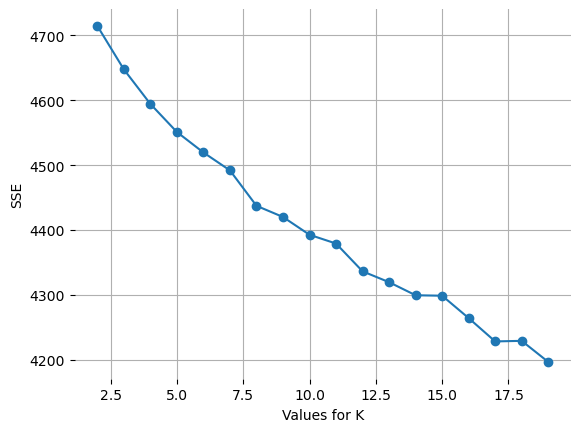

In [ ]:
#Test increments of 100 clusters using elbow method
sse={}
for k in np.arange(2,20,1):
    kmeans = KMeans(n_clusters=k, max_iter=1000,random_state=14).fit(X_selected)
    sse[k] = kmeans.inertia_
plt.plot(list(sse.keys()),list(sse.values()),marker = 'o')
plt.xlabel('Values for K')
plt.ylabel('SSE')
plt.grid()
plt.show();

In [ ]:
#Create clusters
kmeans = KMeans(n_clusters=5,random_state=14)
kmeans.fit(X_selected)
result = pd.concat([dfexecution['Product'],pd.DataFrame(X_selected.toarray(),columns=vectorizer_selected.get_feature_names_out())],axis=1)
result['cluster'] = kmeans.predict(X_selected)

In [ ]:
#result.to_csv('Output_KMeansClusters.csv')

## Cluster Quality

### Cluster Names & Word Cloud

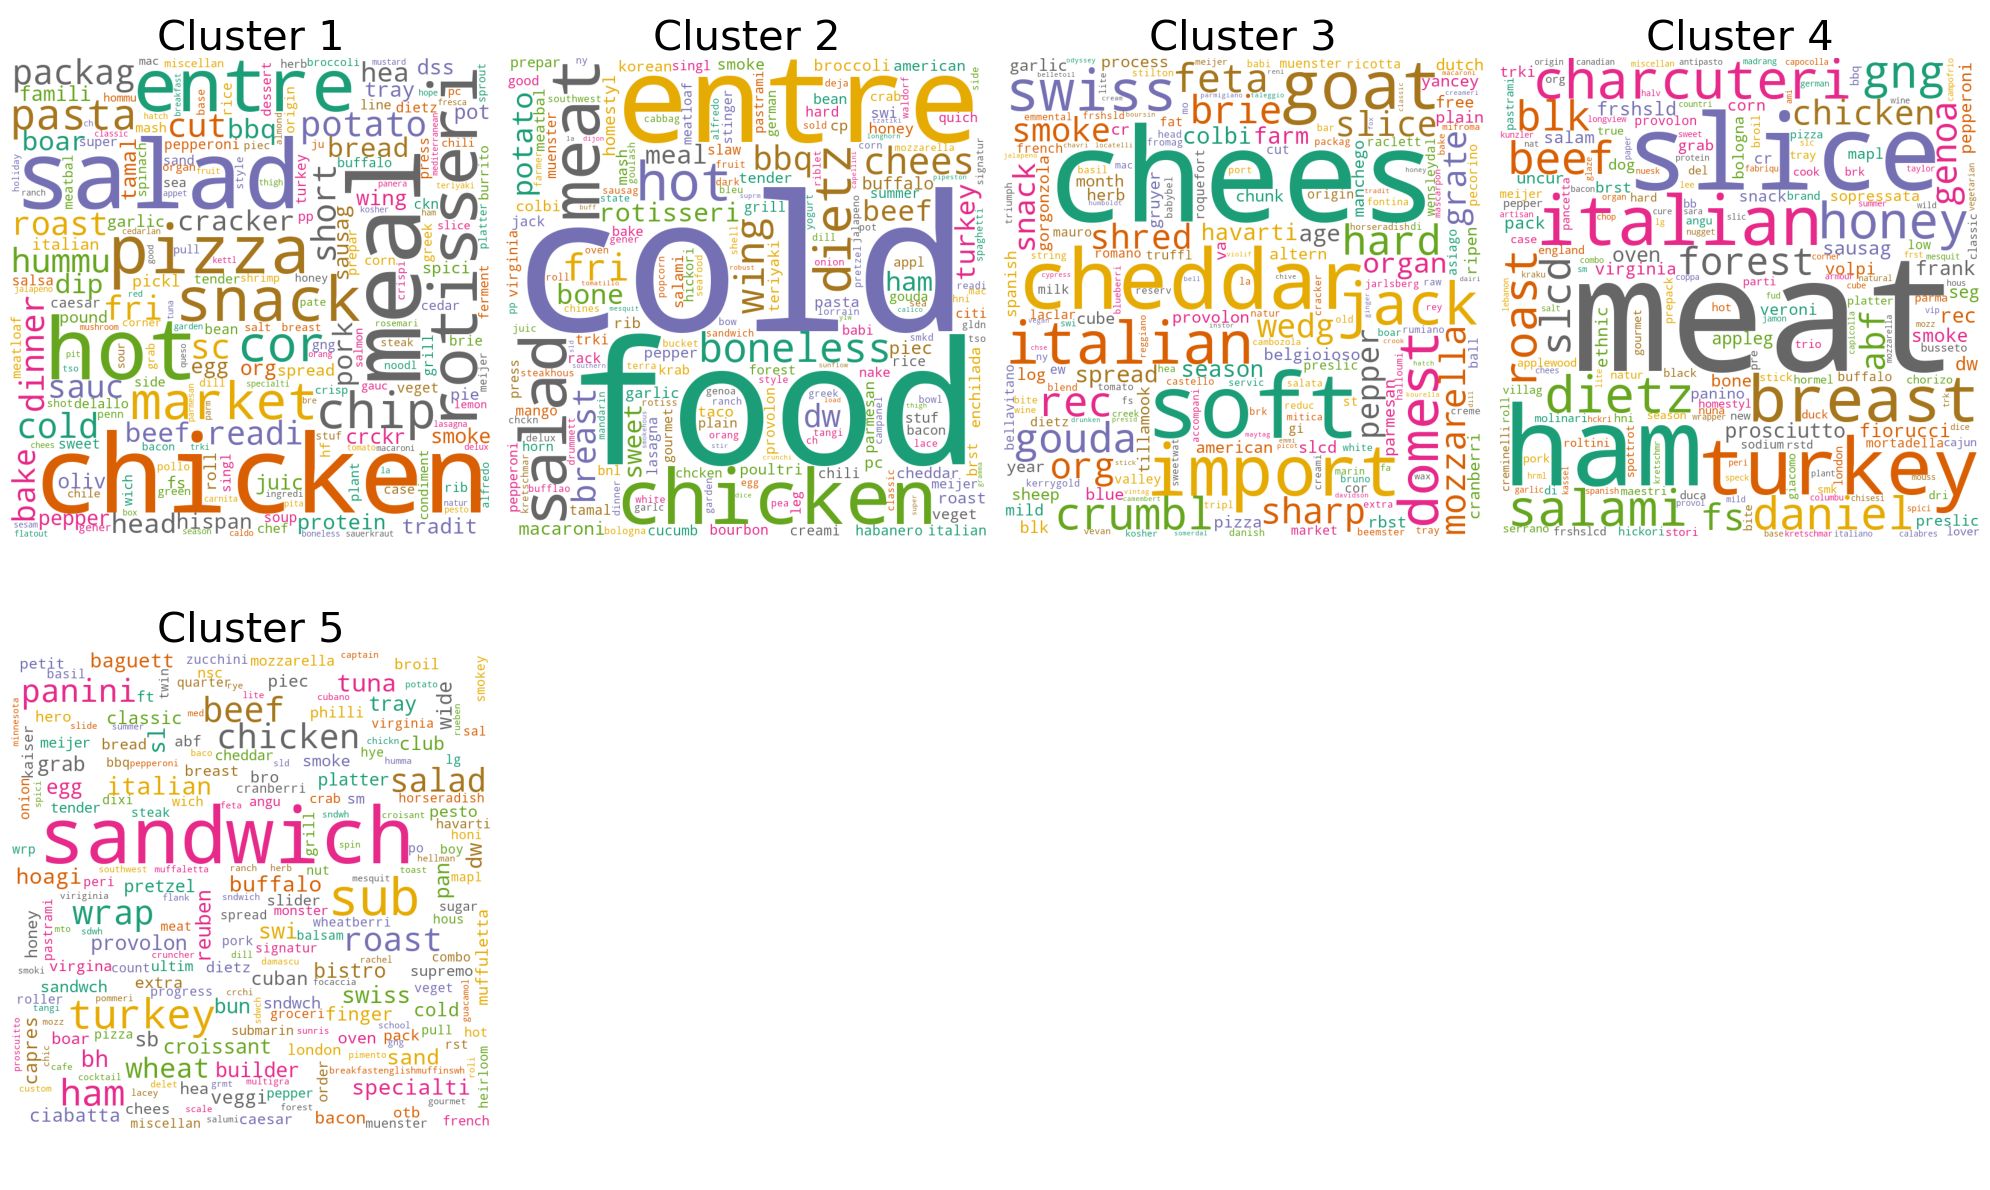

In [ ]:
clusters = np.sort(result['cluster'].unique()) #Find count of unique clusters built
appended_clusters = []
labels = []

#Setting config for wordcloud subplots
count_of_clusters = len(np.sort(result['cluster'].unique()))
plots_per_row = 4
plot_rows = math.ceil(count_of_clusters / plots_per_row)

plots_rows = np.int64(np.ceil(len(clusters)/plots_per_row))
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False

if plot_rows <= 2:
    fig, ax = plt.subplots(plots_rows, plots_per_row, figsize=(20,12), sharex=True)
elif plot_rows == 3:
    fig, ax = plt.subplots(plots_rows, plots_per_row, figsize=(20,18), sharex=True)
elif plot_rows == 4:
    fig, ax = plt.subplots(plots_rows, plots_per_row, figsize=(20,22), sharex=True)  
else:
    fig, ax = plt.subplots(plots_rows, plots_per_row, figsize=(20,25), sharex=True)  
    
#ax = axes.flatten()
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]) #Turn off axes
#fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.tight_layout()
    
for i in range(len(clusters)):
    subset = result[result['cluster'] == clusters[i]]
    
    # Lets convert the vectors table into a frequency table showing which vector is most common for given cluster
    subsetgroup = pd.DataFrame(data = subset.groupby('cluster').agg(sum)).T
    subsetgroup['title']=subsetgroup.index
    subsetgroup = subsetgroup.rename_axis(None, axis=1).rename_axis('id', axis=0).reset_index(drop=True) #rename index col name
    subsetgroup['clusterid']=subsetgroup.columns[0]
    clusternum = subsetgroup.columns[0]
    subsetgroup = subsetgroup.rename({subsetgroup.columns[0]: 'count'}, axis=1).reset_index(drop=True)  # rename the col, also rename col by position.
    subsetgroup = subsetgroup.sort_values(by=['count'],ascending=False).reset_index(drop = True)
    subsetgroup = subsetgroup.reindex(columns=['clusterid','title','count']) #rearrange columns
    appended_clusters.append(subsetgroup) #appending all cluster infor to single dataframe
    
    #Lets now find name for this cluster by joining the top 10 most occuring labels as a single space separated string
    topwords = subsetgroup[:10]
    topwords = topwords['title'].groupby(np.repeat(np.arange(len(topwords)), 10)[:len(topwords)]).agg(' '.join)
    labels.append(str(clusternum+1) + ' - ' + ''.join(topwords[0]))
    
    #Word Cloud
    ax = fig.add_subplot(plots_rows, plots_per_row,i+1)
    subsetplotdict = dict(zip(subsetgroup['title'],subsetgroup['count'])) #Create a frequency dict for Word Cloud.
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    colormap='Dark2',
                    stopwords = STOPWORDS)
    wordcloud.generate_from_frequencies(subsetplotdict)    
    ax.set_title(f'Cluster {clusters[i]+1}',fontdict={'fontsize': 30})
    ax.axis('off')
    ax.set_frame_on(False)
    ax.imshow(wordcloud)        
    

In [ ]:
#Now Labels can be added back to dfexecution and output can be exported
labels_table = pd.DataFrame(zip(clusters,labels),columns=['cluster','label'])
result_labelled = pd.merge(result,labels_table,on='cluster',how='left')
Output_ResultLabelled = pd.concat([dfexecution,result['cluster'],result_labelled['label']],axis=1)
Output_ResultLabelled.to_csv("Output_ResultLabelled.csv")
pd.pivot_table(result_labelled,index=['label'],values=['Product'],aggfunc='count').sort_values(['Product'],ascending=False)

,Product
label,
1 - chicken meal salad hot entre pizza rotisseri snack market chip,1978
3 - chees soft cheddar import goat jack italian swiss domest crumbl,1500
4 - meat ham slice turkey italian breast charcuteri dietz honey salami,566
2 - cold food entre chicken meat salad hot dietz boneless wing,459
5 - sandwich sub turkey ham beef chicken wrap roast salad panini,364


In [ ]:
# ###
# ### This didnt work properly because all clusters dont have common repeating work, so commenting out
# ###
# #Label each cluster with the word(s) that all of its food names have in common
# clusters = result['cluster'].unique()
# labels = []
# for i in range(len(clusters)):
#     subset = result[result['cluster'] == clusters[i]]
#     words = ' '.join([x for x in np.where(subset.all()!=0,subset.columns,None) if x and x!='Product' and x!='cluster' and len(x.split()) == 1])
#     labels.append(words)
# labels_table = pd.DataFrame(zip(clusters,labels),columns=['cluster','label'])
# result_labelled = pd.merge(result,labels_table,on='cluster',how='left')

In [ ]:
#result_labelled[['Product','cluster','label']].head()

### Cluster Sizing

In [ ]:
pd.pivot_table(result_labelled,index=['label'],values=['Product'],aggfunc='count').sort_values(['Product'],ascending=False)

In [ ]:
result_labelled = pd.concat([result_labelled,dfexecution['Client']],axis=1)

In [ ]:
pd.pivot_table(result_labelled,index=['Client','label'],values=['Product'],aggfunc='count').sort_values(['Client','Product'],ascending=False)

In [ ]:
#Visualise sizes of supermarket categories (manually added to result_labelled) and clean clusters
result_summary = pd.pivot_table(result_labelled,index=['label','Client'],values=['Product'],aggfunc='count').reset_index().rename(columns={'Product':'count'})
result_treemap = result_summary[(result_summary['label'] != '') & (result_summary['count'] > 1)]
fig = px.treemap(result_treemap,path=['Client','label'],values='count')
fig.show();

### Visualization

In [ ]:
df_plt = result_labelled.groupby(['Client','label'],as_index=False)['Product'].count()

In [ ]:
df_plt[df_plt['label']==''].sum()

In [ ]:
_blanks = df_plt[df_plt['label']==''].sum() 
_total = result_labelled['Product'].count()
1 - _blanks.Product / _total

In [ ]:
plt.scatter(df_plt['Client'], df_plt['label'], s=df_plt['Product'])